## Libraries:

In [2]:
pip install tfkerassurgeon

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import glob
import numpy as np
# import csv
from itertools import compress
import rasterio
import random
import json
import math
import time
import os
import sys
# Self written functions
from helpers.helpers_read_data import *
from helpers.helpers_models import *
from helpers.helpers_performance_analytics import *


## Data:

In [4]:
images_path = "./Kenya_Landsat7_1y_before_election_scale30"
ps_data_path = "./kenya13_vars.json"
image_data, image_ps_id = read_stllt_images_and_names(images_path)
images_data_dict = dict(zip(image_ps_id,image_data))

In [5]:
import pandas as pd
raw_dat = pd.read_csv('./final-for-analysis.csv')

dat = pd.concat([raw_dat['psid'],
                 # turnout
                 raw_dat["turnout_count"], raw_dat["registered_voters"], 
                 # ethnic frac (let's simply average...)
                 raw_dat['ethnic_frac'],
                 # other PS level data
                 raw_dat['terrain_elevation'], raw_dat['terrain_ruggedness'],
                   raw_dat['terrain_slope'],raw_dat['poverty_rate'], raw_dat['literacy_rate'],
                   raw_dat['dependency_ratio'],raw_dat['skilled_birth_att'],
                   raw_dat['night_lights'],raw_dat['county_name']], axis=1)


dat_ps = dat.groupby('psid').agg({
    # preparing for turnout
    'turnout_count': 'sum',
    'registered_voters': 'sum',
    # assumption. but fair approx for now, since all streams have (sort of) same weight
    'ethnic_frac': 'mean',
    # Polling Station level anyway
    'terrain_elevation': 'first',
    'terrain_ruggedness': 'first',
    'terrain_slope': 'first',
    'poverty_rate': 'first',
    'literacy_rate': 'first',
    'dependency_ratio': 'first',
    'skilled_birth_att': 'first',
    'night_lights': 'first',
    'county_name': 'first',
})

/opt/anaconda3/envs/tf2_vi/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
# turn rown names from grouping into own column
dat_ps.index.name = 'psid'
dat_ps.reset_index(inplace=True)
# replace the / for a - to be in sync with the image names
dat_ps['psid'] = dat_ps['psid'].str.replace('/','-')


In [7]:
dat_ps['registered_voters'] = dat_ps['registered_voters'].replace(0, np.NaN)
dat_ps['turnout'] = dat_ps["turnout_count"]/dat_ps['registered_voters']
dat_ps['turnout'].values[dat_ps['turnout'] > 1] = np.NaN
# drop NaNs
dat_ps = dat_ps.dropna()
# turn into dictionary for polling stations
# ps_data_dict = dict(zip(list(dat_ps['psid']), list(dat_ps['turnout'])))
# 
dat_ps = pd.get_dummies(dat_ps, columns=['county_name'], prefix='', prefix_sep='')

unique_ps_id = list(set(list(dat_ps['psid'])))
# assert each id occurs only once
assert len(unique_ps_id)==dat_ps.shape[0]

ps_id_at_ps_level = list(dat_ps['psid'])
# turnout_at_ps_level = list(dat_ps['turnout'])
images_at_ps_level_wona = []
mask = [True]*len(ps_id_at_ps_level)
for i in range(len(ps_id_at_ps_level)):
    try:
        images_at_ps_level_wona.append(images_data_dict[ps_id_at_ps_level[i]])
    except:
        mask[i] = False
dat_ps_wona = dat_ps[mask]
print('We do not have data for',len(ps_id_at_ps_level) - len(images_at_ps_level_wona),'sat images. \n')
# this generates the data we need for the model
dat_ps_features_wona = dat_ps_wona.copy()
turnout_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout'))
ps_id_at_ps_level_wona = list(dat_ps_features_wona.pop('psid'))
turnout_count_at_ps_level_wona = list(dat_ps_features_wona.pop('turnout_count'))
registered_voters_at_ps_level_wona = list(dat_ps_features_wona.pop('registered_voters'))
assert (dat_ps_features_wona.shape[0] == len(ps_id_at_ps_level_wona) == 
        len(images_at_ps_level_wona) == len(turnout_at_ps_level_wona)), 'Something went wrong in the data generation. There are different lengths'

We do not have data for 6 sat images. 



In [8]:
new_order = random.sample(range(len(turnout_at_ps_level_wona)), len(turnout_at_ps_level_wona))
# defines train-test-val size
observed_ps_set_size = len(turnout_at_ps_level_wona)
testval_set_size = math.floor(.1*observed_ps_set_size)
# train_set_size = observed_ps_set_size - 2*testval_set_size
train_set_size = observed_ps_set_size - testval_set_size


In [9]:
image_data_all_bands = np.stack(images_at_ps_level_wona, axis = 0)
image_data_all_bands = image_data_all_bands.reshape((observed_ps_set_size, 96, 96, 7))
train_images = image_data_all_bands[new_order[0:train_set_size],:,:,:].reshape(train_set_size, 96, 96, 7)
# val_images = image_data_all_bands[new_order[train_set_size:(train_set_size+testval_set_size)],:,:,:].reshape((testval_set_size, 96, 96, 7))
# test_images = image_data_all_bands[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))
test_images = image_data_all_bands[new_order[train_set_size:observed_ps_set_size],:,:,:].reshape((testval_set_size, 96, 96, 7))
train_ps_data = np.array(dat_ps_features_wona)[new_order[0:train_set_size],:]
# val_ps_data = np.array(dat_ps_wona_features)[new_order[train_set_size:(train_set_size+testval_set_size)],:]
# test_ps_data = np.array(dat_ps_wona_features)[new_order[(train_set_size+testval_set_size):observed_ps_set_size],:]
test_ps_data = np.array(dat_ps_features_wona)[new_order[train_set_size:observed_ps_set_size],:]
normalizer = Normalization()
normalizer.adapt(np.array(train_ps_data))
train_ps_data_normalized =normalizer(train_ps_data)
test_ps_data_normalized =normalizer(test_ps_data)
train_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[0:train_set_size]])
# val_labels = [turnout_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
test_labels = np.array([turnout_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]])
train_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[0:train_set_size]]
# val_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:(train_set_size+testval_set_size)]]
test_ps_id = [ps_id_at_ps_level_wona[i] for i in new_order[train_set_size:observed_ps_set_size]]


## Models:

#### Inception Model with Expansion:

In [10]:
### Inception V3 transfer learning
def model_inception_V3(img_height = 96, img_width = 96, n_channel = 3, n_rlu = 1024, dropout_prop = .5, activation = 'elu'):
    # initialize the trained inception V3 model
    base_model = InceptionV3(
        weights = 'imagenet', include_top = False, 
        input_shape = (img_height, img_width, n_channel))
    # add a global spatial average pooling layer
    last_layer = base_model.output
    last_layer = GlobalAveragePooling2D()(last_layer)
    # normalize the batch
    BatchNormalization()
    # add a fully-connected layer
    last_layer = Dense(n_rlu, activation = activation)(last_layer)
    # add a dropout layer
    last_layer = Dropout(dropout_prop)(last_layer)
    # get the predictions through the sigmoid layer
    out = Dense(1, activation = 'sigmoid', name = 'output_layer')(last_layer)
    # put it together into one model
    network = Model(inputs = base_model.input, outputs = out)
    # freeze all but the final two fc. 3 here, because there is the dropout in between
    max_layers = len(network.layers)
    for layer in network.layers[:(max_layers - 3)]:
        layer.trainable = False
    for layer in network.layers[(max_layers - 3):]:
        layer.trainable = True
    # return the model
    return(network)

In [11]:
from keras.applications.inception_v3 import InceptionV3
# load model
model = model_inception_V3()
# summarize the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 47, 47, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 47, 47, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
weights = model.get_weights()

In [13]:
num_hs_channels = 4

rgb_weights = np.array(weights[0])
assert(rgb_weights.shape == (3,3,3,32))

rgb_mean = rgb_weights.mean(axis=2, keepdims=True)  # shape [F, F, 1, 64] (from yeh et al. scripy)
hs_weights = np.tile(rgb_mean, (1, 1, num_hs_channels, 1))

# now scale the weights with the number of hs channels
rgb_weights *= 3 / (3 + num_hs_channels)
hs_weights *= 3 / (3 + num_hs_channels)
final_first_layer_weights = np.concatenate((rgb_weights, hs_weights), axis = 2)
final_first_layer_weights = np.expand_dims(final_first_layer_weights, axis = 0)
assert(final_first_layer_weights.shape == (1,3,3,7,32))

In [14]:
tmp = model.get_config()
tmp['layers'][0]['config']['batch_input_shape'] = (None, 96, 96, 7) 
model = Model.from_config(tmp)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 47, 47, 32)   2016        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 47, 47, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 47, 47, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
w_fc = np.clip(np.random.normal(size = (2048, 1024)), -2, 2)
b_fc = np.clip(np.random.normal(size = 1024), -2, 2)
new_weights_fc = [w_fc, b_fc]

In [16]:
# last layer
w_ll = np.clip(np.random.normal(size = (1024, 1)), -2, 2)
b_ll = np.clip(np.random.normal(size = 1), -2, 2)
new_weights_ll = [w_ll, b_ll]

In [17]:
# first layer
model.layers[1].set_weights(final_first_layer_weights)
# second last layer
model.layers[312].set_weights(new_weights_fc)
# final layer
model.layers[314].set_weights(new_weights_ll)

In [18]:
batch_size_set = [32]
learning_rate_set = ['default']
model_set = ['model']
optimizer_set = ['rmsprop']

In [19]:
network = model
best_model_path = './best_models/inception_weights_0_1.h5'
network.compile(optimizer='rmsprop',
                    loss='mse',
                    metrics=['mae'])
    # select best models, but with early stopping
early_stopper = EarlyStopping(monitor='val_mae', patience=3,
    mode='min', min_delta=0.0001)
checkpoint = ModelCheckpoint(best_model_path, monitor='val_mae', verbose=1,
    save_best_only=True, mode='min')
callbacks_list = [early_stopper, checkpoint]
history = network.fit(train_images, train_labels,
            epochs=15 , batch_size= 32, callbacks=callbacks_list,
            validation_data=(test_images, test_labels))

Epoch 1/15
619/619 [==============================] - 223s 354ms/step - loss: 0.0880 - mae: 0.1947 - val_loss: 0.0244 - val_mae: 0.1301

Epoch 00001: val_mae improved from inf to 0.13014, saving model to ./best_models/inception_weights_0_1.h5
Epoch 2/15
619/619 [==============================] - 239s 386ms/step - loss: 0.0247 - mae: 0.1305 - val_loss: 0.0244 - val_mae: 0.1301

Epoch 00002: val_mae did not improve from 0.13014
Epoch 3/15
619/619 [==============================] - 246s 397ms/step - loss: 0.0244 - mae: 0.1299 - val_loss: 0.0244 - val_mae: 0.1301

Epoch 00003: val_mae did not improve from 0.13014
Epoch 4/15
619/619 [==============================] - 243s 392ms/step - loss: 0.0248 - mae: 0.1305 - val_loss: 0.0244 - val_mae: 0.1301

Epoch 00004: val_mae did not improve from 0.13014
Epoch 5/15
619/619 [==============================] - 246s 398ms/step - loss: 0.0246 - mae: 0.1302 - val_loss: 0.0244 - val_mae: 0.1301

Epoch 00005: val_mae did not improve from 0.13014
Epoch 6/1

In [25]:
network.load_weights(best_model_path)
network.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])
val_mse, val_mae = network.evaluate(test_images, test_labels)

69/69 [==============================] - 18s 238ms/step - loss: 0.0244 - mae: 0.1298


In [26]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 96, 96, 7),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': False,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (3, 3),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'BatchNormalization',

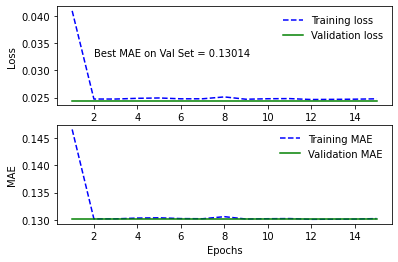

In [28]:
plot_path = ("best_models/"+'/'+"inception7channel"+"_figure.png")
performance_plotter(history, plot_path, val_mae)
val_performance_path = ('best_models/'+'/'+'inecption7channels'+'_best_val_performance.csv')
with open(val_performance_path, 'w',encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(zip([val_mse], [val_mae]))